# Overview
Here, I want to run a set of simulations in which the model tries to maximize the demand met within a certain distance.
It is limited by the number of hubs it can build and the capactiy of each hub
Variables to change:
1. Number of hubs to build
2. Maximum distance the people can travel
I suspect that, as I increase the maximum distance, the hubs that will be built will be larger and more distant than for smaller distances.


In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import importlib
from data_cleaning import hub_occ_dict
from data_cleaning import hub_sqft_dict
from data_cleaning import heatdays_df
from data_cleaning import cengeo_pop_dict
from data_cleaning import bg_ces_df
import demand_maximization_models as dem_models

distmatrix_df = pd.read_csv(os.path.join("data","distmatrix_bbox.csv"))
distmatrix_df.rename(columns = {"Unnamed: 0":"GISJOIN"},inplace=True)
distmatrix_df.set_index("GISJOIN",inplace=True)

hubs_df = pd.read_csv(os.path.join("data","candidate_site_campuses_2021-11-17","candidate_sites_campuses.csv"),
                      index_col='id_site')
blockgroup_gdf = gpd.read_file(os.path.join("data","bg_ca_19","blockgroup_CA_19.shp"))
blockgroup_df = blockgroup_gdf[["INTPTLAT","INTPTLON","GISJOIN"]].copy().set_index("GISJOIN")
blockgroup_gdf = blockgroup_gdf.set_index("GISJOIN")

In [4]:
importlib.reload(dem_models) # in case the code for demand_maximization_models.py is changed

##################USER VARIABLES#########################
max_hubs_list =[50,100,150]
max_distance_list = [1,3,5]
##################END OF USER VARIABLES#########################

prop_served_dict = dict()
hub_yn_dict = dict()

for max_hubs in max_hubs_list:
    for max_distance in max_distance_list:
        prop_served_dict[(max_hubs,max_distance)], hub_yn_dict[(max_hubs,max_distance)] = dem_models.build_demand_max_model(max_hubs,
                                   max_distance,
                                   distmatrix_df,
                                   hub_sqft_dict,
                                   cengeo_pop_dict,
                                   hub_occ_dict)
        run_string = "Contra_"+str(max_hubs)+"hubs"+str(max_distance)+"miles_max"
        try:
            os.mkdir(os.path.join("results",run_string))
        except OSError as error:
            print(error)
        prop_served_dict[(max_hubs,max_distance)].to_csv(os.path.join("results",
                                                                      run_string,
                                                                      "var_prop_served.csv"))
        hub_yn_dict[(max_hubs,max_distance)].to_csv(os.path.join("results",
                                                                 run_string,
                                                                 "var_hub_yn.csv"))


Time to solve model:  0.5901563000000039
[WinError 183] Cannot create a file when that file already exists: 'results\\Contra_50hubs1miles_max'
Time to solve model:  2.0338696000000027
[WinError 183] Cannot create a file when that file already exists: 'results\\Contra_50hubs3miles_max'
Time to solve model:  2.448861999999991
[WinError 183] Cannot create a file when that file already exists: 'results\\Contra_50hubs5miles_max'
Time to solve model:  1.0079275000000223
[WinError 183] Cannot create a file when that file already exists: 'results\\Contra_100hubs1miles_max'
Time to solve model:  1.9599606999999821
[WinError 183] Cannot create a file when that file already exists: 'results\\Contra_100hubs3miles_max'
Time to solve model:  2.776799699999998
[WinError 183] Cannot create a file when that file already exists: 'results\\Contra_100hubs5miles_max'
Time to solve model:  1.0989371000000006
[WinError 183] Cannot create a file when that file already exists: 'results\\Contra_150hubs1miles_ma

# Beginning of Visualization

## Map


In [37]:
import plotly.graph_objects as go # or plotly.express as px
import plotly.express as px
################USER VARIABLES#####################
# Change this section however you like, it just needs to get the
# two variables var_prop_served and var_hub_yn in order to work
max_hubs_entry = 1
max_distance_entry = 1
max_hubs = max_hubs_list[max_hubs_entry]
max_distance = max_distance_list[max_distance_entry]
var_prop_served = prop_served_dict[(max_hubs,max_distance)]
var_hub_yn = hub_yn_dict[(max_hubs,max_distance)]
###################################################

hubs_not_built = var_hub_yn.index[var_hub_yn[0]==0]
hubs_not_built = [str(h) for h in hubs_not_built if str(h) in var_prop_served.columns]
hubs_not_built_df = hubs_df.loc[hubs_not_built,:]

hubs_built = var_hub_yn.index[var_hub_yn[0]==1]
hubs_built = [str(h) for h in hubs_built if str(h) in var_prop_served.columns]
hubs_built_df = hubs_df.loc[hubs_built,:]

blockgroup_df_local = blockgroup_df.loc[var_prop_served.index.to_list(),:].copy()
blockgroup_df_local = blockgroup_df_local.merge(bg_ces_df,on="GISJOIN")
blockgroup_df_local.set_index("GISJOIN",inplace=True)

dists = dict()
for r in range(distmatrix_df.shape[0]):
    idx_real = np.where(distmatrix_df.iloc[r,:].notnull())
    dist_dict = dict(distmatrix_df.iloc[r,idx_real[0]])
    dists[distmatrix_df.index[r]] = dist_dict

pairs = dict()
for r in range(var_prop_served.shape[0]):
    idx_real = np.where((var_prop_served.iloc[r,:].notnull())&(var_prop_served.iloc[r,:]>0))
    pair_dict = dict(var_prop_served.iloc[r,idx_real[0]])
    pairs[var_prop_served.index[r]] = pair_dict

# BUILT HUBS MARKERS
fig_map = go.Figure(go.Scattermapbox(lat=hubs_built_df["LAT"], lon=hubs_built_df["LON"],
                                 mode='markers',
                                marker=go.scattermapbox.Marker(
                                    size=20*np.sqrt(hubs_built_df["SQFT_ROOF"])/np.max(np.sqrt(hubs_built_df["SQFT_ROOF"])),
                                    color='rgb(255, 0, 0)',
                                    opacity=1.0,
                                    # symbol = "castle"
                                ),
                                # marker_symbol = 'circle-open',
                                text=hubs_built_df["name_site"],
                                hoverinfo='text',
                                name = 'Built hubs'
                                 )
                )

# UNBUILT HUBS MARKERS
fig_map.add_trace(go.Scattermapbox(lat=hubs_not_built_df["LAT"], lon=hubs_not_built_df["LON"],
                                    mode='markers',
                                    marker=go.scattermapbox.Marker(
                                        size=20*np.sqrt(hubs_not_built_df["SQFT_ROOF"])/np.max(np.sqrt(hubs_not_built_df["SQFT_ROOF"])),
                                        color='rgb(100, 0, 50)',
                                        opacity=0.5
                                        ),
                                    text=hubs_not_built_df["name_site"],
                                    hoverinfo='text',
                                    name = 'Unbuilt hubs'
                                    )
                )

# BLOCKGROUP MARKERS
fig_map.add_trace(go.Scattermapbox(lat=blockgroup_df_local["INTPTLAT"], lon=blockgroup_df_local["INTPTLON"],
                                  mode='markers',
                                  marker=go.scattermapbox.Marker(
                                      size=20 * blockgroup_df_local["BLOCKGROUPPOP19"]/np.max(blockgroup_df_local["BLOCKGROUPPOP19"]),
                                      color='rgb(0, 150, 255)',opacity=0.7
                                ),
                                text=blockgroup_df_local.index,
                                hoverinfo='text',
                                name = 'Blockgroups'
                                 )
                )

# EDGES CONNECTING HUB AND BLOCKGROUP PAIRS
lons_pairs = []
lats_pairs = []
names_pairs = []
for bg in pairs:
    for hub in pairs[bg]:
        lons_pairs.append(float(blockgroup_df.loc[bg,"INTPTLON"]))
        lats_pairs.append(float(blockgroup_df.loc[bg,"INTPTLAT"]))
        lons_pairs.append((float(blockgroup_df.loc[bg,"INTPTLON"])+float(hubs_df.loc[str(hub),"LON"]))/2)
        lats_pairs.append((float(blockgroup_df.loc[bg,"INTPTLAT"])+float(hubs_df.loc[str(hub),"LAT"]))/2)
        lons_pairs.append(float(hubs_df.loc[str(hub),"LON"]))
        lats_pairs.append(float(hubs_df.loc[str(hub),"LAT"]))
        names_pairs.append(None)
        names_pairs.append("Proportion of demand: " + str(pairs[bg][hub])+", Travel distance: "+str(distmatrix_df.loc[bg,hub]))
        names_pairs.append(None)
        lons_pairs.append(None)
        lats_pairs.append(None)
        names_pairs.append(None)

fig_map.add_trace(go.Scattermapbox(mode = "lines",lon = lons_pairs,lat = lats_pairs,text = names_pairs,hovertext = names_pairs,
    # marker = {'size': 1,'opacity':1.0}), 
    line = {'width':0.5,'color':'rgb(245,245,245)'},    
    name = 'Assigned demand'))

# BACKGROUND MAPS TO CHOOSE FROM
# carto-darkmatter, carto-positron, open-street-map, stamen-terrain, stamen-toner, stamen-watercolor, white-bg

fig_map.update_layout(mapbox=dict(center=dict(lat=38,lon=-122),
                               zoom=9
                               ),
                #   mapbox_style="open-street-map",
                  mapbox_style="carto-darkmatter",
                  height = 700,
                  title = "Maximum hubs: " + str(max_hubs) + ", Maximum travel distance: " + str(max_distance) + " miles"
                  )

fig_map.show()


## Some statistics
1. Histograms of how much demand is being met across all blockgroups (is it all or nothing or a mixture?)
2. Cumulative distribution function of the size of the built hubs (are bigger or smaller hubs being built?)
3. CES score of the population being served versus not served
4. Cumulative distribution of the distance travelled

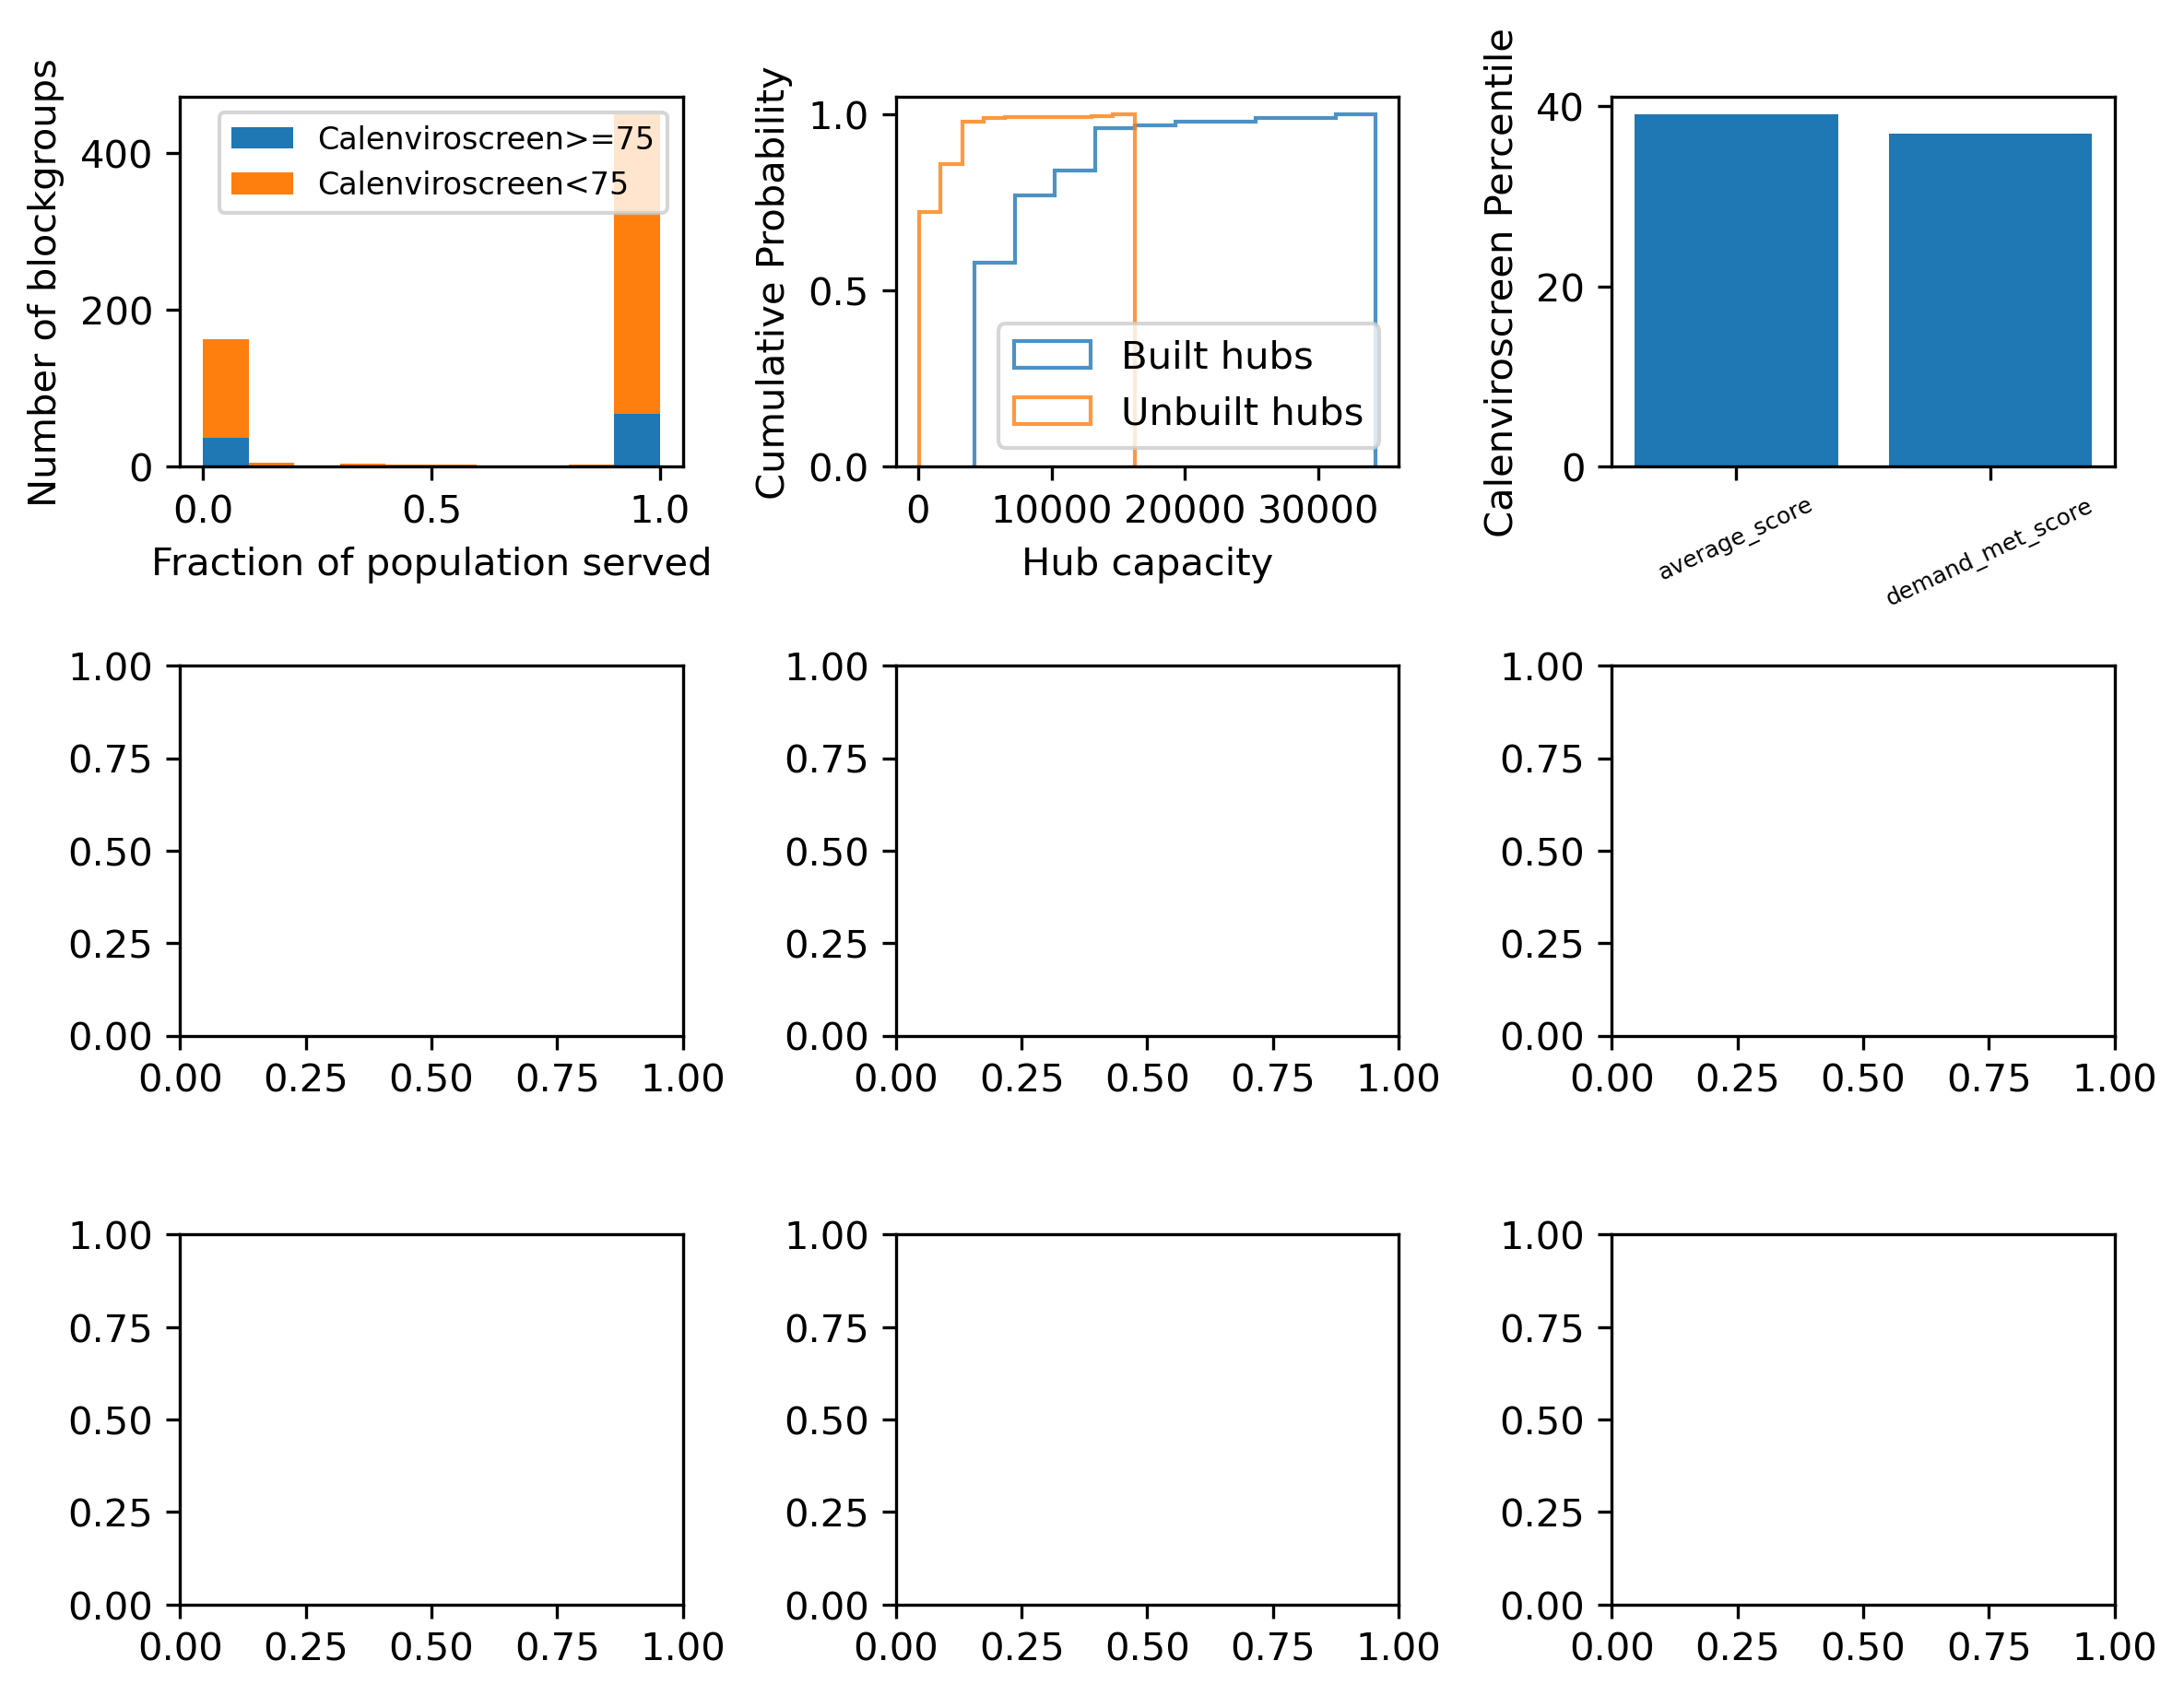

In [100]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3,3,figsize = (8,6),dpi=300)

################USER VARIABLES#####################
# Change this section however you like, it just needs to get the
# two variables var_prop_served and var_hub_yn in order to work
max_hubs_entry = 1
max_distance_entry = 1
max_hubs = max_hubs_list[max_hubs_entry]
max_distance = max_distance_list[max_distance_entry]
var_prop_served = prop_served_dict[(max_hubs,max_distance)]
var_hub_yn = hub_yn_dict[(max_hubs,max_distance)]
####################################################
# GETTING DATA FROM VARIABLES
hubs_not_built = var_hub_yn.index[var_hub_yn[0]==0]
hubs_not_built = [str(h) for h in hubs_not_built if str(h) in var_prop_served.columns]
hubs_not_built_df = hubs_df.loc[hubs_not_built,:]

hubs_built = var_hub_yn.index[var_hub_yn[0]==1]
hubs_built = [str(h) for h in hubs_built if str(h) in var_prop_served.columns]
hubs_built_df = hubs_df.loc[hubs_built,:]

blockgroup_df_local = blockgroup_df.loc[var_prop_served.index.to_list(),:].copy()
blockgroup_df_local = blockgroup_df_local.merge(bg_ces_df,on="GISJOIN")
blockgroup_df_local.set_index("GISJOIN",inplace=True)

####################################################
# BLOCKGROUP TOTAL DEMAND MET HISTOGRAMS
EJ_bg = [bg for bg in var_prop_served.index if bg in bg_ces_df[bg_ces_df["SCORE_PCTL_CI_BG"]>=75]["GISJOIN"].to_list()]
not_EJ_bg = [bg for bg in var_prop_served.index if bg in bg_ces_df[bg_ces_df["SCORE_PCTL_CI_BG"]<75]["GISJOIN"].to_list()]
axs[0,0].hist([var_prop_served.loc[EJ_bg].sum(axis=1),
                var_prop_served.loc[not_EJ_bg].sum(axis=1)],
                label = ("Calenviroscreen>=75","Calenviroscreen<75"),
                stacked=True, # histtype=u'step'
                )
axs[0,0].legend(fontsize = 8)
axs[0,0].set_xlabel("Fraction of population served")
axs[0,0].set_ylabel("Number of blockgroups")

####################################################
# CDF OF HUB CAPCITIES
axs[0,1].hist([hub_occ_dict[hub] for hub in hubs_built], density=True, cumulative=True, label='Built hubs',histtype='step', alpha=0.8)
axs[0,1].hist([hub_occ_dict[hub] for hub in hubs_not_built], density=True, cumulative=True, label='Unbuilt hubs',histtype='step', alpha=0.8)
axs[0,1].legend(loc='lower right')
axs[0,1].set_xlabel("Hub capacity")
axs[0,1].set_ylabel("Cumulative Probability")
plt.tight_layout()

####################################################
# Calenviroscreen percentiles
total_fraction_demand_met = var_prop_served.sum(axis=1)
total_fraction_demand_met.rename("total_fraction_demand_met",inplace=True)
blockgroup_df_local = blockgroup_df_local.merge(total_fraction_demand_met,left_index=True,right_index=True)
score_dict = dict()
score_dict["average_score"] = np.sum(blockgroup_df_local["SCORE_PCTL_CI_BG"]*(blockgroup_df_local["BLOCKGROUPPOP19"]/np.sum(blockgroup_df_local["BLOCKGROUPPOP19"])))
score_dict["demand_met_score"] = np.sum(blockgroup_df_local["SCORE_PCTL_CI_BG"]*((blockgroup_df_local["total_fraction_demand_met"]*blockgroup_df_local["BLOCKGROUPPOP19"])/(np.sum(blockgroup_df_local["total_fraction_demand_met"]*blockgroup_df_local["BLOCKGROUPPOP19"]))))
axs[0,2].bar(range(len(score_dict)),list(score_dict.values()),tick_label = list(score_dict.keys()))
axs[0,2].set_ylabel("Calenviroscreen Percentile")
axs[0,2].tick_params(axis='x', labelrotation= 25,labelsize=6)

plt.tight_layout()
# plt.savefig("Proportion_served_hist.png")

459.66810379935333

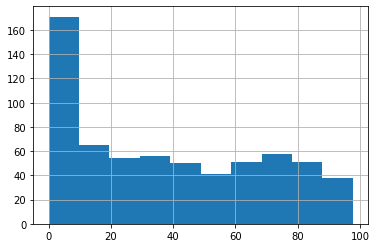

In [98]:
demand_met_score
blockgroup_df_local["SCORE_PCTL_CI_BG"].hist()
list(score_dict.values())
np.sum(blockgroup_df_local["total_fraction_demand_met"])

In [57]:
bg_ces_df[bg_ces_df["SCORE_PCTL_CI_BG"]>75]["GISJOIN"]
# blockgroup_local_df[blockgroup_local_df["SCORE_PCTL_CI_BG"]>75]
EJ_bg = [bg for bg in var_prop_served.index if bg in bg_ces_df[bg_ces_df["SCORE_PCTL_CI_BG"]>=75]["GISJOIN"].to_list()]
not_EJ_bg = [bg for bg in var_prop_served.index if bg in bg_ces_df[bg_ces_df["SCORE_PCTL_CI_BG"]<75]["GISJOIN"].to_list()]
not_EJ_bg

['G06001303010001',
 'G06001303010002',
 'G06001303020051',
 'G06001303020052',
 'G06001303020053',
 'G06001303020054',
 'G06001303020061',
 'G06001303020062',
 'G06001303020071',
 'G06001303020072',
 'G06001303020081',
 'G06001303020082',
 'G06001303020091',
 'G06001303020092',
 'G06001303020101',
 'G06001303020102',
 'G06001303020103',
 'G06001303020104',
 'G06001303031021',
 'G06001303031022',
 'G06001303031031',
 'G06001303031032',
 'G06001303031033',
 'G06001303031034',
 'G06001303032011',
 'G06001303032012',
 'G06001303032013',
 'G06001303032021',
 'G06001303032022',
 'G06001303032023',
 'G06001303032024',
 'G06001303032031',
 'G06001303032041',
 'G06001303032042',
 'G06001303032043',
 'G06001303032051',
 'G06001303032052',
 'G06001303040011',
 'G06001303040021',
 'G06001303040031',
 'G06001303040032',
 'G06001303040033',
 'G06001303040041',
 'G06001303040042',
 'G06001303040051',
 'G06001303040052',
 'G06001303060021',
 'G06001303060033',
 'G06001303060041',
 'G06001303060042',


In [59]:
len(not_EJ_bg)

526